<a href="https://colab.research.google.com/github/broskunta/PyTorch-Linear-Regression/blob/main/Logistic_Regression_Mean_Square_Error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Logistic Regression and Bad Initialization Value
* How bad initialization value can affect model accuracy.

In [2]:
# import the libraries needed
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [3]:
# Create class for plotting and the function for plotting

class plot_error_surfaces(object):

    # Construstor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - (1 / (1 + np.exp(-1*w2 * self.x - b2)))) ** 2)
                count2 += 1
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()

     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)

    # Plot diagram
    def final_plot(self):
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.plot(self.x, 1 / (1 + np.exp(-1 * (self.W[-1] * self.x + self.B[-1]))), label='sigmoid')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')

# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg=True):
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass

In [4]:
# set the random seed
torch.manual_seed(0)

### Get Some Data

In [5]:
# Create the data class

class Data(Dataset):

    # Constructor
    def __init__(self):
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        self.y = torch.zeros(self.x.shape[0], 1)
        self.y[self.x[:, 0] > 0.2] = 1
        self.len = self.x.shape[0]

    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # Get Length
    def __len__(self):
        return self.len

In [6]:
#make data object
data_set = Data()

### Create the Model and Total Loss Function (Cost)

In [7]:
# Create logistic_regression class

class logistic_regression(nn.Module):

    # Constructor
    def __init__(self, n_inputs):
        super(logistic_regression, self).__init__()
        self.linear = nn.Linear(n_inputs, 1)

    # Prediction
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat

In [8]:
# create model
model = logistic_regression(1)

In [9]:
# set the parameters
model.state_dict()['linear.weight'].data[0] = torch.tensor([[-5]])
model.state_dict()['linear.bias'].data[0] = torch.tensor([[-10]])
print("The parameters are:", model.state_dict())

The parameters are: OrderedDict([('linear.weight', tensor([[-5.]])), ('linear.bias', tensor([-10.]))])


<Figure size 640x480 with 0 Axes>

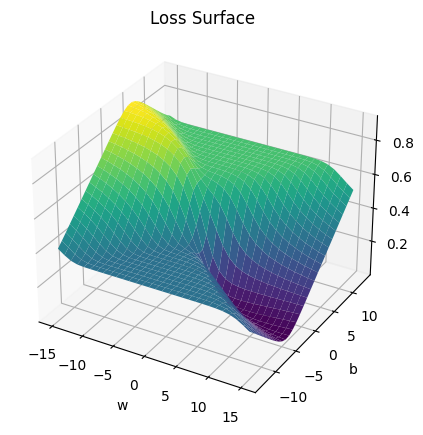

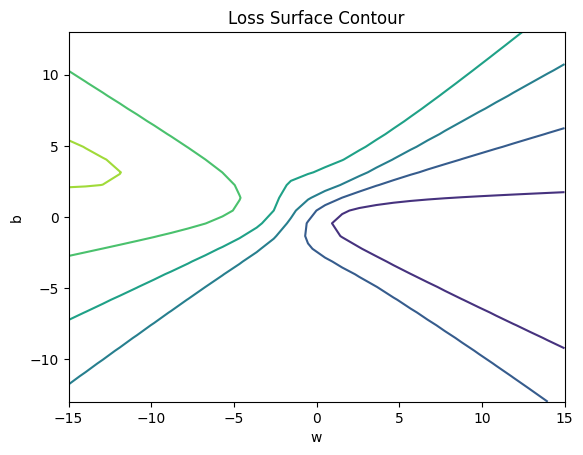

In [10]:
# create error plot surface
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

In [12]:
# define dataloader
trainloader = DataLoader(dataset=data_set, batch_size=1)
criterion = nn.MSELoss()
learning_rate = 2
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

### Train the model via Batch Gradient Descent

In [14]:
# train the model

def train_model(epochs):
    for epoch in range(epochs):
        for x,y in trainloader:
            #make pred
            yhat = model(x)
            #cal loss
            loss = criterion(yhat, y)
            #zero the grad
            optimizer.zero_grad()
            #back pass
            loss.backward()
            # update parameters
            optimizer.step()
            #get plot
            get_surface.set_para_loss(model, loss.tolist())
        if epoch % 20 == 0:
            get_surface.plot_ps()

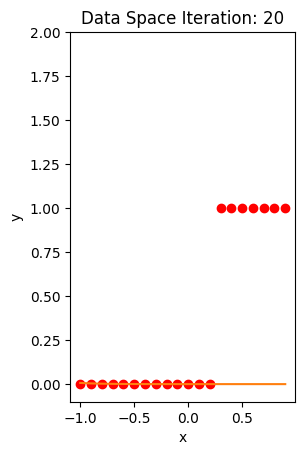

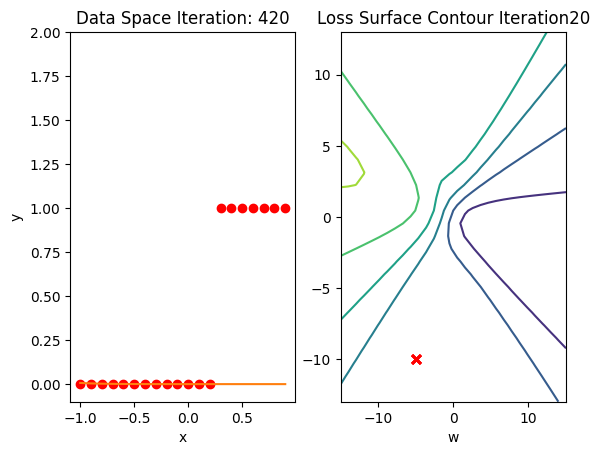

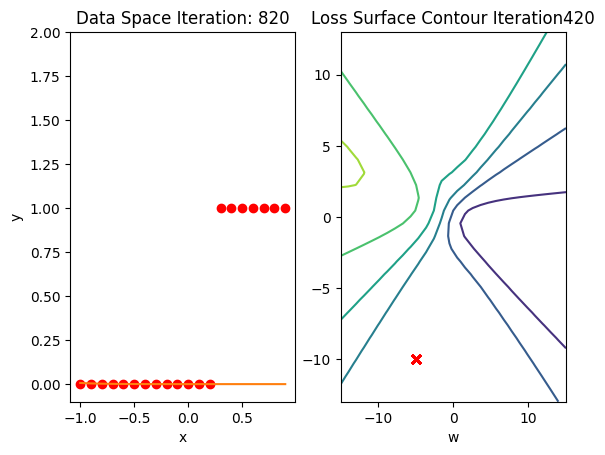

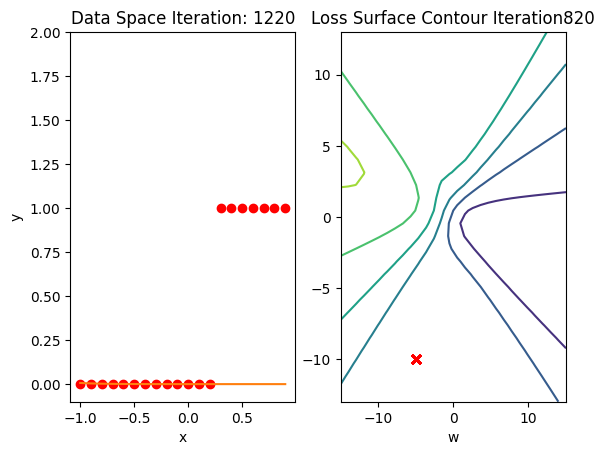

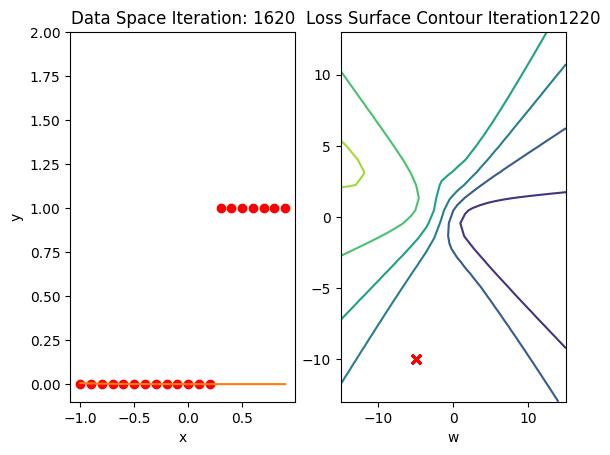

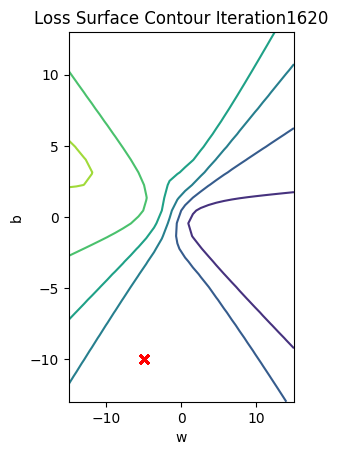

In [15]:
# train the model
train_model(100)

In [16]:
#make prediction
yhat = model(data_set.x)
label = yhat > 0.5
print("The accuracy: ", torch.mean((label == data_set.y.type(torch.ByteTensor)).type(torch.float)))

The accuracy:  tensor(0.6500)
